In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)
from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3

import numpy as np
import scipy as sp
import astropy.units as u
from astropy.constants import c

In [2]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.468, -1.178, -2.117]  # Slopes for initial mass function
nbin12 = [5, 5, 20]

# Output times for the evolution
tout = np.array([11000])

# Integration settings
N0 = 5e5  # Normalization of stars
Ndot = -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [3]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=100,
)

/home/peter/research/ssptools/ssptools/evolve_mf_3.py:321: RuntimeWarning: divide by zero encountered in true_divide
  As = Ns / P1
/home/peter/research/ssptools/ssptools/evolve_mf_3.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  Aj = Nj / self.Pk(alphaj, 1, m1, mto)


In [4]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])

In [5]:
print(mj[:nms])

[0.11851084 0.16351292 0.22560363 0.31127202 0.42947124 0.53616312
 0.6158897  0.70747148 0.80754321]


In [6]:
print("mj  | q: 0.5 \t 0.75 \t 0.95")
print("-------------------------------")
for i in range(nms):
    print(f"{mj[i]:.2f} \t {mj[i]*0.5:.3f} \t {mj[i]*0.75:.3f} \t {mj[i]*0.95:.3f}")

mj  | q: 0.5 	 0.75 	 0.95
-------------------------------
0.12 	 0.059 	 0.089 	 0.113
0.16 	 0.082 	 0.123 	 0.155
0.23 	 0.113 	 0.169 	 0.214
0.31 	 0.156 	 0.233 	 0.296
0.43 	 0.215 	 0.322 	 0.408
0.54 	 0.268 	 0.402 	 0.509
0.62 	 0.308 	 0.462 	 0.585
0.71 	 0.354 	 0.531 	 0.672
0.81 	 0.404 	 0.606 	 0.767


In [7]:
class BinaryShift:
    def __init__(self, mj, Mj, ifmr):
        """
        Initialize an instance of `BinaryShift` with the provided mass bins and IFMR, (TODO)
        the IFMR will (eventually) be used to label the object type of each bin.
        """

        if len(mj) != len(Mj):
            raise ValueError("mj and Mj must have the same length.")

        self.mj = mj
        self.Mj = Mj
        self.ifmr = ifmr

        # TODO Here use ifmr to label the bins, dont take in nms as arg

    def dump(self):
        """
        Dump current config of `BinaryShift`.
        """
        print(f"{self.mj = }")
        print(f"{self.Mj = }")

        try:
            print(f"{self.q = }")
        except:
            pass

        try:
            print(f"{self.fb = }")
        except:
            pass
        # TODO add in things that *might* be set like fb, q etc

    def shift_equal(self, fb, q, nms):
        """
        Shift mass to create binaries of equal mass, amount of mass shifted is determined by `fb`.
        """

        if fb > 1.0 or fb < 0:
            raise ValueError("fb must be between 0 and 1.")

        self.q = 1
        self.fb = fb

        # dont mess with original
        mj = self.mj.copy()
        Mj = self.Mj.copy()

        # loop through the mass bins
        for i in range(nms):

            print()
            print(f"current mj: {mj[i]:.3f}")

            # get mass of companion
            companion_mass = mj[i] * self.q
            print(f"{companion_mass = :.3f}")

            # mass of new bin
            mj_bin = mj[i] + companion_mass
            print(f"new mass: {mj_bin:.3f} ")

            # if the companion is smaller than the lightest MS bin, just skip it
            if companion_mass < np.min(mj):
                print(
                    f"companion mass {companion_mass:.3f} smaller than {np.min(mj):.3f}, skipping"
                )
                pass
            else:

                # total mass in binaries for this new bin
                Mj_bin = Mj[i] * self.fb
                print(f"total mass in binaries {Mj_bin:.3f}")

                # add in the new mean mass bin
                mj = np.append(mj, mj_bin)

                # add in the new total mass bin
                Mj = np.append(Mj, Mj_bin)

                # remove the mass from the old total mass bin
                Mj[i] -= Mj_bin
        return mj, Mj

    def shift_q(self, fb, q, nms):
        """
        Shift mass in to binaries with mass function `q`, amount of mass shifted determined by `fb`.
        (TODO) Eventually this will support lists of `fb` and `q`.
        """

        if q > 1.0 or q < 0:
            raise ValueError("q must be between 0 and 1.")

        if fb > 1.0 or fb < 0:
            raise ValueError("fb must be between 0 and 1.")

        self.fb = fb
        self.q = q

        # dont mess with original
        mj = self.mj.copy()
        Mj = self.Mj.copy()

        # loop through the mass bins
        for i in range(nms):
            print()
            print(f"current mj: {mj[i]:.3f}")

            # get mass of companion
            companion_mass = mj[i] * self.q
            print(f"{companion_mass = :.3f}")

            # if the companion is smaller than the lightest MS bin, just skip it
            if companion_mass < np.min(mj):
                print(
                    f"companion mass {companion_mass:.3f} smaller than {np.min(mj):.3f}, skipping"
                )
                pass
            else:

                # find closest bin to companion mass
                companion_idx = np.argmin(np.abs(mj[:nms] - companion_mass))
                print(f"closest {companion_idx = }")
                # here change the mass of the companion to the mass of the closest bin (TODO: do we want this?)
                companion_mass = mj[companion_idx]
                print(f"closest {companion_mass = :.3f}")

                # mass of new bin
                binary_mj = mj[i] + companion_mass
                print(f"new mass: {binary_mj:.3f} ")

                # get total mass of new binary bin, will be (fb * mj) + (fb * compaion mass bin)
                primary_Mj = self.fb * Mj[i]
                companion_Mj = self.fb * Mj[companion_idx]

                binary_Mj = primary_Mj + companion_Mj

                # add in new binary mean mass bin
                mj = np.append(mj, binary_mj)

                # add total mass to new binary bin
                Mj = np.append(Mj, binary_Mj)

                # remove mass from both primary, companion bins
                Mj[i] -= primary_Mj
                Mj[companion_idx] -= companion_Mj

        return mj, Mj

    def shift_kroupa():
        """
        (TODO) Shift mass according to `fb` and `q` determined by random draw from Kroupa IMF.
        """
        pass

    def shift_solar():
        """
        (TODO) Shift mass according to `fb` and `q` in the solar neigborhood.
        """
        pass

In [8]:
bs = BinaryShift(mj=mj, Mj=Mj, ifmr=None)

In [9]:
bs.dump()

self.mj = array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])
self.Mj = array([3.50653839e+03, 5.74173527e+03, 9.40172964e+03, 1.53947409e+04,
       2.52079221e+04, 1.45666174e+04, 1.63248118e+04, 1.82952210e+04,
       1.85600328e+04, 4.28216163e+04, 3.68811585e+04, 8.56110667e+03,
       8.87107346e+03, 2.04048921e+04, 2.87933957e+03, 3.38905042e+00,
       6.98416820e+00, 1.30644215e+01, 2.60412400e+01, 5.68695470e+01,
       4.17703060e+01])


In [10]:
mj_new, Mj_new = bs.shift_q(fb=0.3, q=0.7, nms=nms)


current mj: 0.119
companion_mass = 0.083
companion mass 0.083 smaller than 0.119, skipping

current mj: 0.164
companion_mass = 0.114
companion mass 0.114 smaller than 0.119, skipping

current mj: 0.226
companion_mass = 0.158
closest companion_idx = 1
closest companion_mass = 0.164
new mass: 0.389 

current mj: 0.311
companion_mass = 0.218
closest companion_idx = 2
closest companion_mass = 0.226
new mass: 0.537 

current mj: 0.429
companion_mass = 0.301
closest companion_idx = 3
closest companion_mass = 0.311
new mass: 0.741 

current mj: 0.536
companion_mass = 0.375
closest companion_idx = 4
closest companion_mass = 0.429
new mass: 0.966 

current mj: 0.616
companion_mass = 0.431
closest companion_idx = 4
closest companion_mass = 0.429
new mass: 1.045 

current mj: 0.707
companion_mass = 0.495
closest companion_idx = 5
closest companion_mass = 0.536
new mass: 1.244 

current mj: 0.808
companion_mass = 0.565
closest companion_idx = 5
closest companion_mass = 0.536
new mass: 1.344 


In [11]:
mj

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])

In [12]:
mj_new

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993, 0.38911655, 0.53687564, 0.74074325, 0.96563436,
       1.04536093, 1.2436346 , 1.34370633])

(0.0, 1.7)

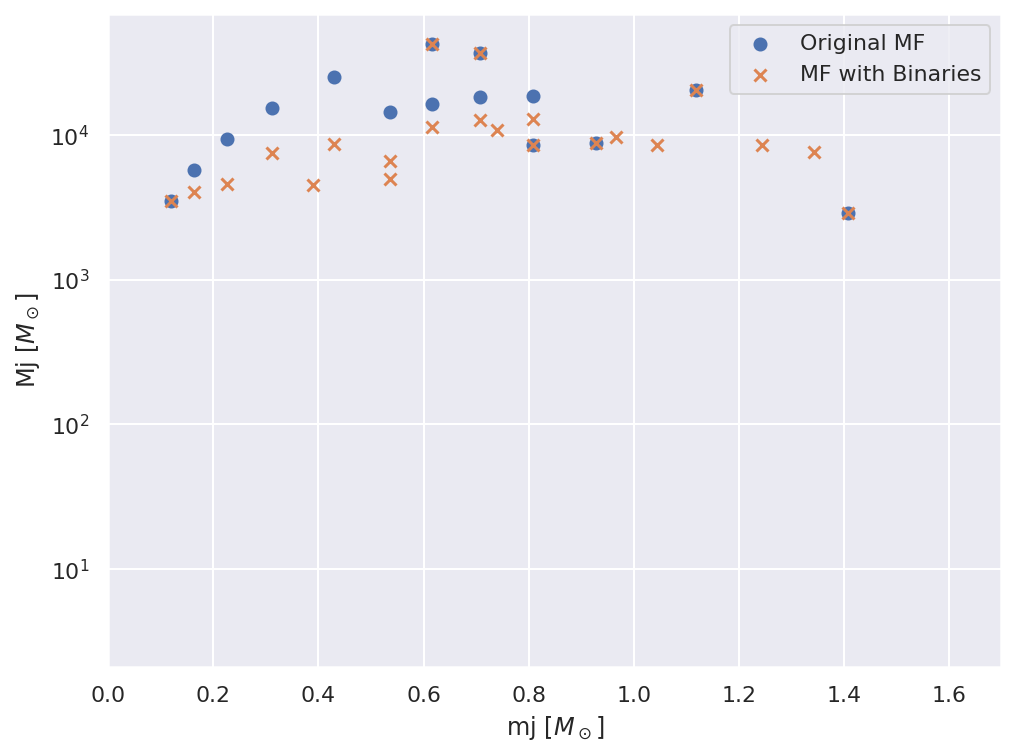

In [13]:
plt.figure()
plt.scatter(mj, Mj, label="Original MF")
plt.yscale("log")
plt.scatter(mj_new, Mj_new, label="MF with Binaries", marker="x")
plt.legend()
plt.ylabel(r"Mj [$M_\odot$]")
plt.xlabel(r"mj [$M_\odot$]")
plt.xlim(0, 1.7)

In [14]:
bs.dump()

self.mj = array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])
self.Mj = array([3.50653839e+03, 5.74173527e+03, 9.40172964e+03, 1.53947409e+04,
       2.52079221e+04, 1.45666174e+04, 1.63248118e+04, 1.82952210e+04,
       1.85600328e+04, 4.28216163e+04, 3.68811585e+04, 8.56110667e+03,
       8.87107346e+03, 2.04048921e+04, 2.87933957e+03, 3.38905042e+00,
       6.98416820e+00, 1.30644215e+01, 2.60412400e+01, 5.68695470e+01,
       4.17703060e+01])
self.q = 0.7
self.fb = 0.3


In [15]:
print(f"{np.sum(Mj) = :.3f} {np.sum(Mj_new) = :.3f}")

np.sum(Mj) = 247566.655 np.sum(Mj_new) = 247566.655
